## 导入数据集

[TOC]

In [1]:
import json
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import bokeh
import pylab

In [2]:
data1 = pd.read_csv('./data/covid19.csv')

In [3]:
data2 = data1.set_index('Observation Date')

In [4]:
data3 = data2.loc['15-03-2020']

## 分省份分析（湖北省单独分析）
- 分省份的总感染人数、分省份的总死亡人数、分省份的总治愈人数
- 分省份的平均每日新增感染人数、平均每日新增死亡人数、平均每日新增治愈人数
- 分省份的治愈率、死亡率
- 分省份的变化趋势
- 高感染省份（TOP3）的变化趋势、高治愈率省份的变化趋势

- 分省份的总感染人数、分省份的总死亡人数、分省份的总治愈人数

In [5]:
confirmed = data3['Confirmed']
deaths = data3['Deaths']
recover = data3['Recovered']

region = data3['Province/State']
data_conf = pd.concat([region, confirmed], axis = 1)
data_death = pd.concat([region, deaths], axis = 1)
data_rec = pd.concat([region, recover], axis = 1)


In [6]:
data_conf2 = data_conf.reset_index().drop('Observation Date', axis = 1)
data_death2 = data_death.reset_index().drop('Observation Date', axis = 1)
data_rec2 = data_rec.reset_index().drop('Observation Date', axis = 1)

hb_conf = data_conf2[data_conf2['Province/State'] == 'Hubei']
hb_death = data_death2[data_death2['Province/State'] == 'Hubei']
hb_rec = data_rec2[data_rec2['Province/State'] == 'Hubei']

data_death3 = data_death2.drop(12, axis = 0)
data_rec3 = data_rec2.drop(12, axis = 0)
data_conf3 = data_conf2.drop(12, axis = 0)

In [7]:
all_data = pd.concat([data_conf3, data_death3, data_rec3], axis = 1, ).drop('Province/State', axis = 1)

In [8]:
all_data['Province'] = data_death3['Province/State']

Matplotlib分析：

C:\Users\Administrator\anaconda3\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


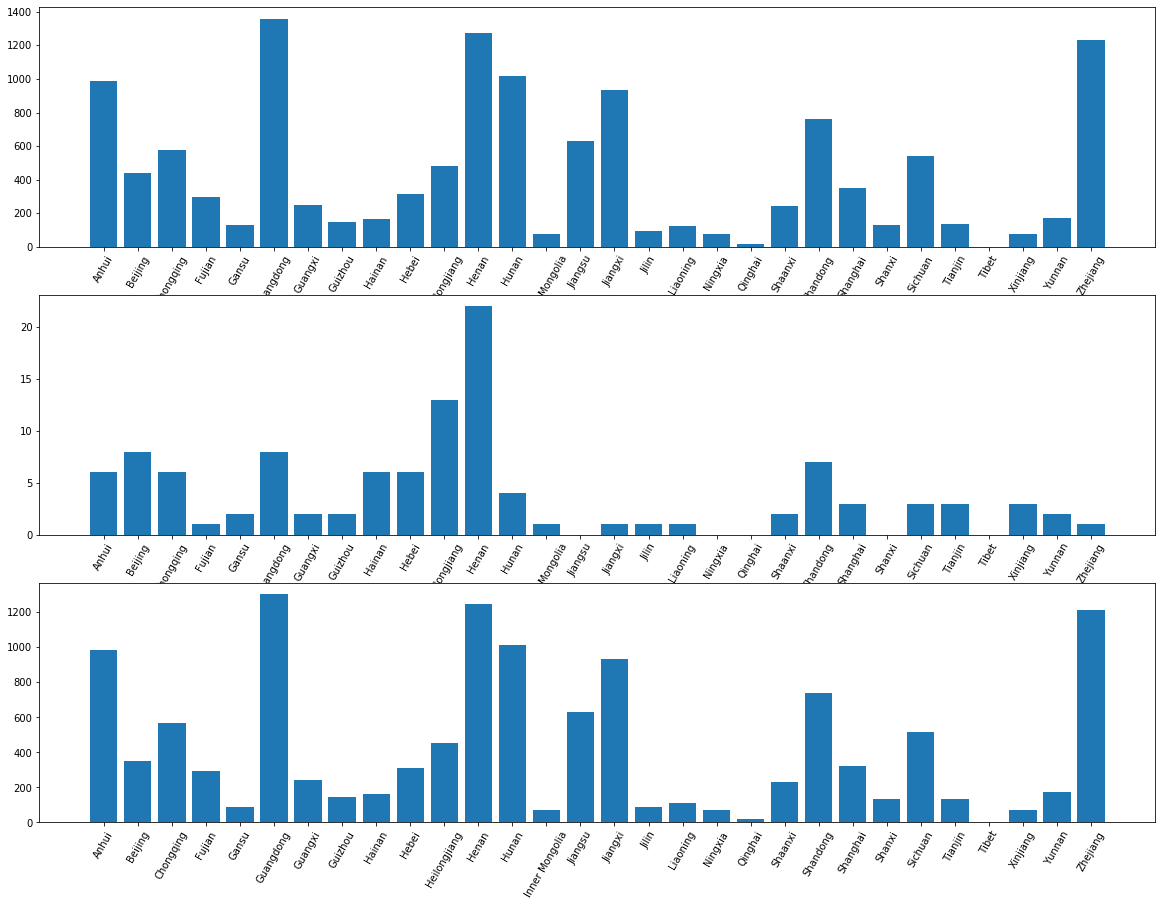

In [9]:
fig1 = plt.figure(figsize = (20,15))
ax1 = fig1.add_subplot(311)
ax1.bar(data_conf3['Province/State'], data_conf3['Confirmed'])
pylab.xticks(rotation = 60)

ax2 = fig1.add_subplot(312)
ax2.bar(data_death3['Province/State'], data_death3['Deaths'])
pylab.xticks(rotation = 60)

ax3 = fig1.add_subplot(313)
ax3.bar(data_rec3['Province/State'], data_rec3['Recovered'])
pylab.xticks(rotation = 60)

fig1.show()

bokeh展示：

In [10]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Legend, LegendItem, ColumnDataSource, HoverTool

output_notebook()
p = figure(title = 'All Confirmed in China(Except Hubei)', plot_width = 800, plot_height = 500, x_range = all_data['Province'].tolist())

hover_tool = HoverTool(
    tooltips = [
        ("Province", "@Province"),
        ("Confirmed", "@Confirmed"),
        ("Deaths", "@Deaths"),
        ("Recovered", "@Recovered")
    ],
    #mode = 'vline'
)
p.add_tools(hover_tool)

source = ColumnDataSource(data = all_data)

bar1 = p.vbar(x = 'Province', top = 'Confirmed', source = source,width = 0.9, color = 'navy', alpha = 0.6, legend_label = 'Confirmed')
bar2 = p.vbar(x = 'Province', top = 'Deaths', source = source, width = 0.9, color = 'firebrick', alpha = 0.8, legend_label = 'Deaths')
bar3 = p.vbar(x = 'Province', top = 'Recovered', source = source, width = 0.9, color = '#a6cee3', alpha = 0.6, legend_label = 'Recovered')

p.legend.orientation = "horizontal"
p.x_range.range_padding = 0.1
p.legend.location = "top_right"
p.legend.click_policy = 'hide'
p.xaxis.major_label_orientation = 1.2

show(p)

Loading BokehJS ...

- 分省份的平均每日新增感染人数、新增死亡人数、新增治愈人数

In [11]:
def added(x):
    y = []
    for i in range(1,len(x)):
        y.append(x[i] - x[i-1])
    y = np.array(y)
    aver = np.mean(y)
    return aver

In [12]:
data1.head()

,Province/State,Country/Region,Confirmed,Deaths,Recovered,Latitude,Longitude,Observation Date
0,Anhui,Mainland China,1,0,0,32.0,117.0,22-01-2020
1,Anhui,Mainland China,9,0,0,32.0,117.0,23-01-2020
2,Anhui,Mainland China,15,0,0,32.0,117.0,24-01-2020
3,Anhui,Mainland China,39,0,0,32.0,117.0,25-01-2020
4,Anhui,Mainland China,60,0,0,32.0,117.0,26-01-2020


In [13]:
data_prov = data1.set_index('Province/State')
Province = data1['Province/State'].unique()
conf_aver, death_aver, recov_aver = [], [], []
for prov in Province:
    data = data_prov.loc[prov]
    conf_aver.append(added(data['Confirmed'].values))
    death_aver.append(added(data['Deaths'].values))
    recov_aver.append(added(data['Recovered'].values))

Province = pd.DataFrame(Province)
hb_data = []

def return_df(x, name):
    dir_df = pd.DataFrame(x)
    dir_aver = pd.concat([Province, dir_df], axis = 1)
    dir_aver.columns = ['Province', name]
    hb_data.append(dir_aver[dir_aver['Province'] == 'Hubei'])
    dir_aver.drop(12, axis = 0, inplace = True)
    return dir_aver

conf_aver = return_df(conf_aver, 'confirmed')
death_aver = return_df(death_aver, 'deaths')
recov_aver = return_df(recov_aver, 'recovered')

all_data2 = pd.merge(conf_aver, death_aver, on = 'Province')
all_data2 = pd.merge(all_data2, recov_aver, on = 'Province')
#data1.groupby('Province/State').apply(added)

In [14]:
all_data2

,Province,confirmed,deaths,recovered
0,Anhui,18.660377,0.113208,18.566038
1,Beijing,8.075472,0.150943,6.660377
2,Chongqing,10.754717,0.113208,10.754717
3,Fujian,5.566038,0.018868,5.566038
4,Gansu,2.509434,0.037736,1.716981
5,Guangdong,25.169811,0.150943,24.603774
6,Guangxi,4.716981,0.037736,4.584906
7,Guizhou,2.735849,0.037736,2.698113
8,Hainan,3.094340,0.113208,3.018868
9,Hebei,5.981132,0.113208,5.849057


Bokeh展示：

In [15]:
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
from bokeh.models import Legend, LegendItem, ColumnDataSource, HoverTool

#output_notebook()
p2 = figure(title = 'Average Increase in Confirmed/Deaths/Recovered in China(Except Hubei)', plot_width = 800, plot_height = 500, x_range = all_data2['Province'].tolist())

source = ColumnDataSource(data = all_data2)

hover_tool = HoverTool(
    tooltips = [
        ("Province", "@Province"),
        ("Confirmed", "@confirmed"),
        ("Deaths", "@deaths"),
        ("Recovered", "@recovered")
    ],
    #mode = 'vline'
)
p2.add_tools(hover_tool)

bar1 = p2.vbar(x = 'Province', top = 'confirmed', source = source,width = 0.9, color = 'navy', alpha = 0.6, legend_label = 'confirmed')
bar2 = p2.vbar(x = 'Province', top = 'deaths', source = source, width = 0.9, color = 'firebrick', alpha = 0.8, legend_label = 'deaths')
bar3 = p2.vbar(x = 'Province', top = 'recovered', source = source, width = 0.9, color = '#a6cee3', alpha = 0.6, legend_label = 'recovered')

p2.legend.orientation = "horizontal"
p2.x_range.range_padding = 0.1
p2.legend.location = "top_right"
p2.legend.click_policy = 'hide'
p2.xaxis.major_label_orientation = 1.2

show(p2)

- 分省份的治愈率、死亡率、治愈死亡比

治愈率($Rec_1$): $Rec_1 = \frac{总治愈人数}{总感染人数}$

死亡率($Dea_1$): $Dea_1 = \frac{总死亡人数}{总感染人数}$

In [16]:
#data_death2,data_rec2, data_conf2
recrate = pd.concat([data_rec2['Province/State'],data_rec2['Recovered']/data_conf2['Confirmed']], axis = 1)
recrate.columns = ['Province', 'Recover']
dearate = pd.concat([data_death2['Province/State'],data_death2['Deaths']/data_conf2['Confirmed']], axis = 1)
dearate.columns = ['Province', 'Deaths']
Rates = pd.merge(recrate, dearate, on = 'Province')

In [17]:
Rates

,Province,Recover,Deaths
0,Anhui,0.993939,0.006061
1,Beijing,0.798643,0.018100
2,Chongqing,0.989583,0.010417
3,Fujian,0.996622,0.003378
4,Gansu,0.684211,0.015038
5,Guangdong,0.958824,0.005882
6,Guangxi,0.964286,0.007937
7,Guizhou,0.979452,0.013699
8,Hainan,0.952381,0.035714
9,Hebei,0.974843,0.018868


Bokeh展示：

In [18]:
from bokeh.layouts import column

#output_notebook()
p3_1 = figure(title = 'Recover Rate in China', x_range = Rates['Province'].tolist(), plot_width = 800, plot_height = 200)

source = ColumnDataSource(data = Rates)

hover_tool = HoverTool(
    tooltips = [
        ("Province", "@Province"),
        ("Death Rate", "@Deaths"),
        ("Recover Rate", "@Recover")
    ],
    #mode = 'vline'
)
p3_1.add_tools(hover_tool)
bar1 = p3_1.vbar(x = 'Province', top = 'Recover', source = source,width = 0.9, color = 'navy', alpha = 0.6)
p3_1.x_range.range_padding = 0.1
p3_1.y_range.start = 0.5
p3_1.xaxis.major_label_orientation = 1.2

p3_2 = figure(title = 'Death Rate in China',x_range = Rates['Province'].tolist(),  plot_width = 800, plot_height = 200)
bar2 = p3_2.vbar(x = 'Province', top = 'Deaths', source = source, width = 0.9, color = 'firebrick', alpha = 0.6)
p3_2.add_tools(hover_tool)
p3_2.x_range.range_padding = 0.1
p3_2.xaxis.major_label_orientation = 1.2

show(column(p3_1, p3_2))

- 分省份的变化趋势

In [19]:
#这部分可以直接复制

- 高感染省份（TOP3）的变化趋势、高治愈率省份的变化趋势

In [20]:
#Top3 Infection:
print('Top3 Infection:\n', data_conf3.sort_values('Confirmed', ascending = False)[:3])
print('Top3 Recovered:\n',data_rec3.sort_values('Recovered', ascending = False)[:3])
print('Top3 Death Rate:\n', dearate.sort_values('Deaths', ascending = False)[:3])
print('Top5 Recover Rate:\n', recrate.sort_values('Recover', ascending = False)[:5])

Top3 Infection:
    Province/State  Confirmed
5       Guangdong       1360
11          Henan       1273
30       Zhejiang       1231
Top3 Recovered:
    Province/State  Recovered
5       Guangdong       1304
11          Henan       1250
30       Zhejiang       1211
Top3 Death Rate:
     Province    Deaths
12     Hubei  0.045506
28  Xinjiang  0.039474
8     Hainan  0.035714
Top5 Recover Rate:
    Province  Recover
15  Jiangsu  1.00000
27    Tibet  1.00000
24   Shanxi  1.00000
20  Qinghai  1.00000
16  Jiangxi  0.99893


- 对广东、河南、浙江、江苏作出每日新增、每日确诊、每日治愈趋势图

数据提取：

In [21]:
data4 = data1.set_index('Province/State')
gd = data4.loc['Guangdong'].drop(['Latitude', 'Longitude', 'Country/Region'], axis = 1)
hn = data4.loc['Henan'].drop(['Latitude', 'Longitude', 'Country/Region'], axis = 1)
zj = data4.loc['Zhejiang'].drop(['Latitude', 'Longitude', 'Country/Region'], axis = 1)
js = data4.loc['Jiangsu'].drop(['Latitude', 'Longitude', 'Country/Region'], axis = 1)

In [22]:
def get_column(x):
    conf = x.Confirmed.diff(1)
    deat = x.Deaths.diff(1)
    rec = x.Recovered.diff(1)
    df = pd.concat([conf, deat, rec, x['Observation Date']], axis = 1).dropna()
    df = df.reset_index()
    df.columns = ['Province','Confirmed', 'Deaths', 'Recovered', 'Date']
    df['Date'] = pd.to_datetime(df['Date'], format = '%d-%m-%Y')
    return df

In [23]:
gd_added = get_column(gd)
hn_added = get_column(hn)
zj_added = get_column(zj)
js_added = get_column(js)
all_added = [gd_added, hn_added, zj_added, js_added]

In [24]:
js_added.head()

,Province,Confirmed,Deaths,Recovered,Date
0,Jiangsu,4.0,0.0,0.0,2020-01-23
1,Jiangsu,4.0,0.0,0.0,2020-01-24
2,Jiangsu,9.0,0.0,1.0,2020-01-25
3,Jiangsu,15.0,0.0,0.0,2020-01-26
4,Jiangsu,14.0,0.0,0.0,2020-01-27


Bokeh展示：
该图分为三个Part：
1. 每日新增感染，新增感染的四条线颜色一样。
2. 每日新增死亡，新增死亡的四条线颜色一样。
3. 每日新增治愈，新增治愈的四条线颜色一样。
4. 可以按照城市来筛选。

In [26]:
from bokeh.layouts import column, layout
from bokeh.models import ColumnDataSource as CDS
from bokeh.models import Toggle

hover_tool = HoverTool(
    tooltips = [
        ("Province", '@Province'),
        ("Confirmed", "@Confirmed"),
        ("Deaths", "@Deaths"),
        ("Recovered", "@Recovered"),
        ("Date", "@Date{%F}")
    ],
    formatters = {
        "@Date":"datetime",
    },
    #mode = 'vline'
)
plot = figure(x_axis_type = "datetime",title = 'Recover Rate in China',plot_width = 800, plot_height = 500)
plot.add_tools(hover_tool)
toggles = []
for data in all_added:
    source = CDS(data = data)
    p1 = plot.line(y = data['Confirmed'], x = data['Date'], line_color = 'Firebrick',line_alpha = 0.6, line_width = 2, legend_label = 'Confirmed')
    p2 = plot.line(y = 'Deaths', x = 'Date', source = source, line_color = 'Navy',line_alpha = 0.6, line_width = 2,legend_label = 'Deaths')
    p3 = plot.line(y = 'Recovered', x = 'Date', source = source, line_color = '#a6cee3',line_alpha = 0.6, line_width = 2,legend_label = 'Recovered')
    toggle2 = Toggle(label = data['Province'][0], button_type = 'default', active = True, width_policy = 'max', background = 'grey')
    toggle2.js_link('active', p1, 'visible')
    toggle2.js_link('active', p2, 'visible')
    toggle2.js_link('active', p3, 'visible')
    toggles.append(toggle2)

plot.legend.location = "top_right"
plot.legend.click_policy = 'hide'

layouts = layout([plot, toggles])

show(layouts)

## 全国形势分析
- 全国总感染趋势、总感染人口、总死亡人口、总治愈人口
- 全国死亡率、治愈率
- 全国净增加趋势
- 全国数据建模

- 全国总感染趋势、总感染人口、死亡、治愈人口以及净增加趋势

In [27]:
f = open('./data/timeseries.json', 'r')
content = f.read()
a = json.loads(content)
chdata = pd.DataFrame(a['China'])

In [28]:
chdata['date'] = pd.to_datetime(chdata['date'], format = '%Y-%m-%d')

In [29]:
chdata_add = pd.concat([chdata['date'], chdata['confirmed'].diff(1), chdata['deaths'].diff(1), chdata['recovered'].diff(1)], axis = 1).dropna()

In [30]:
p4_1 = figure(x_axis_type = 'datetime', plot_width = 800, plot_height = 250)

source1 = ColumnDataSource(data = chdata)
source2 = ColumnDataSource(data = chdata_add)

hover_tool1 = HoverTool(
    tooltips = [
        ("Confirmed", "@confirmed{0}"),
        ("Deaths", "@deaths{0}"),
        ("Recovered", "@recovered{0}"),
        ("Date", "@date{%F}")
    ],
    formatters = {
        "@date":"datetime",
    },
    #mode = 'vline'
)

p4_1.add_tools(hover_tool1)
area1 = p4_1.varea(y2 = 'confirmed',y1 = 0, x = 'date', source = source1, color = 'firebrick', alpha = 0.5, legend_label = 'Confirmed')
line1 = p4_1.line(y = 'confirmed',x = 'date', source = source1, color = 'firebrick', alpha = 0.8, line_width = 2, legend_label = 'Confirmed')
area2 = p4_1.varea(y2 = 'deaths', y1 = 0, x = 'date', source = source1, color = 'navy', alpha = 0.5, legend_label = 'Deaths')
line2 = p4_1.line(y = 'deaths',x = 'date', source = source1, color = 'navy', alpha = 0.8, line_width = 2, legend_label = 'Deaths')
area3 = p4_1.varea(y2 = 'recovered', y1 = 0, x = 'date', source = source1, color = '#a6cee3', alpha = 0.5, legend_label = 'Recovered')
line3 = p4_1.line(y = 'recovered', x = 'date', source = source1, color = '#a6cee3', alpha = 0.8, line_width = 2, legend_label = 'Recovered')
p4_1.legend.location = "top_right"
p4_1.legend.click_policy = 'hide'
#show(p4_1)

p4_2 = figure(x_axis_type = 'datetime', plot_width = 800, plot_height = 250)
p4_2.add_tools(hover_tool1)
l1 = p4_2.line(y = 'confirmed', x = 'date', source = source2, color = 'firebrick', line_width = 3, legend_label = 'Confirmed')
l2 = p4_2.line(y = 'deaths', x = 'date', source = source2, color = 'navy', line_width = 3, legend_label = 'Deaths')
l3 = p4_2.line(y = 'recovered',x = 'date', source = source2, color = '#a6cee3', line_width = 3, legend_label = 'Recovered')
p4_2.legend.location = "top_right"
p4_2.legend.click_policy = 'hide'

layouts = layout([p4_1, p4_2])
show(layouts)

- 全国死亡率、治愈率

死亡率（$Dea_2$）: $Dea_2 = \frac{全国总死亡人口}{全国总感染人口}$

治愈率（$Rec_2$）：$Rec_2 = \frac{全国总治愈人口}{全国总感染人口}$

In [31]:
total_conf = chdata['confirmed'].iloc[-1]
total_death = chdata['deaths'].iloc[-1]
total_rec = chdata['recovered'].iloc[-1]

In [32]:
print('Death Rate:\t', total_death/total_conf)
print('Recover Rate:\t', total_rec/total_conf)

Death Rate:	 0.054738456094828095
Recover Rate:	 0.9392227398714396


- 全国时间序列数据建模

Bokeh建模：

In [34]:
from bokeh.layouts import column
from bokeh.models import CustomJS, ColumnDataSource, Slider

x = np.linspace(0, 161, 2000)
y = 1/(np.exp(1)**(-x)+1)

source1 = ColumnDataSource(data = dict(x = range(0,161), y = chdata['confirmed']))
source2 = ColumnDataSource(data = dict(x = x, y = y))

plot = figure(plot_width = 400, plot_height = 400)
plot.line('x', 'y', source = source1, line_width = 3, line_alpha = 0.6)
plot.line('x', 'y', source = source2, line_width = 3, line_alpha = 0.6, line_color = 'firebrick')

slider1 = Slider(start = 0, end = 1, value = 0, step = 0.01)
#slider2 = Slider(start = 0, end = 10, value = 1,step = 0.1)
slider3 = Slider(start = -10, end = 10, value = 2 , step = 0.1)
callback = CustomJS(args = dict(source = source2, slider1 = slider1, slider3 = slider3), code = """
    var data = source.data;
    var f1 = slider1.value;
    var f3 = slider3.value;
    var x = data['x'];
    var y = data['y'];
    for (var i = 0; i < x.length; i++){
        y[i] = 84000*(Math.pow(Math.exp(1), f1*x[i])-1)/(f3+Math.pow(Math.exp(1), f1*x[i]))
    }
    source.change.emit();
""")

slider1.js_on_change('value', callback)
#slider2.js_on_change('value', callback)
slider3.js_on_change('value', callback)

show(column(slider1, slider3, plot))